In [1]:
!pip install timm
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38242 sha256=6422d1a4c851024eeed10450d3c59228ea038adcd1558f2ce4ecc4d696be22d9
  Stored in directory: /root/.cache/pip/wheels/a4/6a/11/fa213a7aaae1a99a800b86bdd1cc95bc9c7d7914b0859663b8
Successfully built grad-cam


# ✔Summary
* Using image augmentation (ex. mixup, flip, cropping)

* It appears that there are no outliers in the images in the dataset. The number of images is the same.

* Prevent overfitting with Earlystopping

# ✔Points
* Points used to prevent overfitting
  * augmentation(especially mixup)

* Make sure the model has been trained properly
  * XAI(grad cam)

* Dataset is too small, so It could be overfitting.



# Import

In [2]:
from torch import nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import random
import os
import torch
import cv2
import albumentations as A
import numpy as np
import timm
import torchvision.transforms as transforms
import torchvision

In [3]:
CFG={
    "BATCH":32,
    "LR":1e-4,
    "EPOCH":1000
}

In [4]:
#only train
labels=['children','adults']
image_files=[[os.path.join('/kaggle/input/children-vs-adults-images/train/',label,x) for x in os.listdir(os.path.join('/kaggle/input/children-vs-adults-images/train/',label))] for label in labels]

In [5]:
df_labels={
    'children':0,
    'adults':1
}
image_paths=[]
for i in range(2):
  for j in range(len(image_files[i])):
    current = image_files[i]
    image_paths.append(current[j])

In [6]:
print(f'children image : {len(image_files[0])} adults image : {len(image_files[1])}')

children image : 340 adults image : 340


In [7]:
def seed_everything(seed):
    seed = int(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
seed_everything(34)

# Visualization with augmentation

In [9]:
def aug_random_imshow(idx,name,transform):
  plt.figure(figsize=(10,10))

  image=cv2.imread(f"/kaggle/input/children-vs-adults-images/train/{name}/{idx}.jpg")
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(np.real(image))
  plt.title(f'{name} original')

  augmentations = transform(image=image)
  
  plt.subplot(1,2,2)
  plt.imshow(augmentations["image"])
  plt.title(f'{name} transform')
  plt.axis('off')
  plt.show()

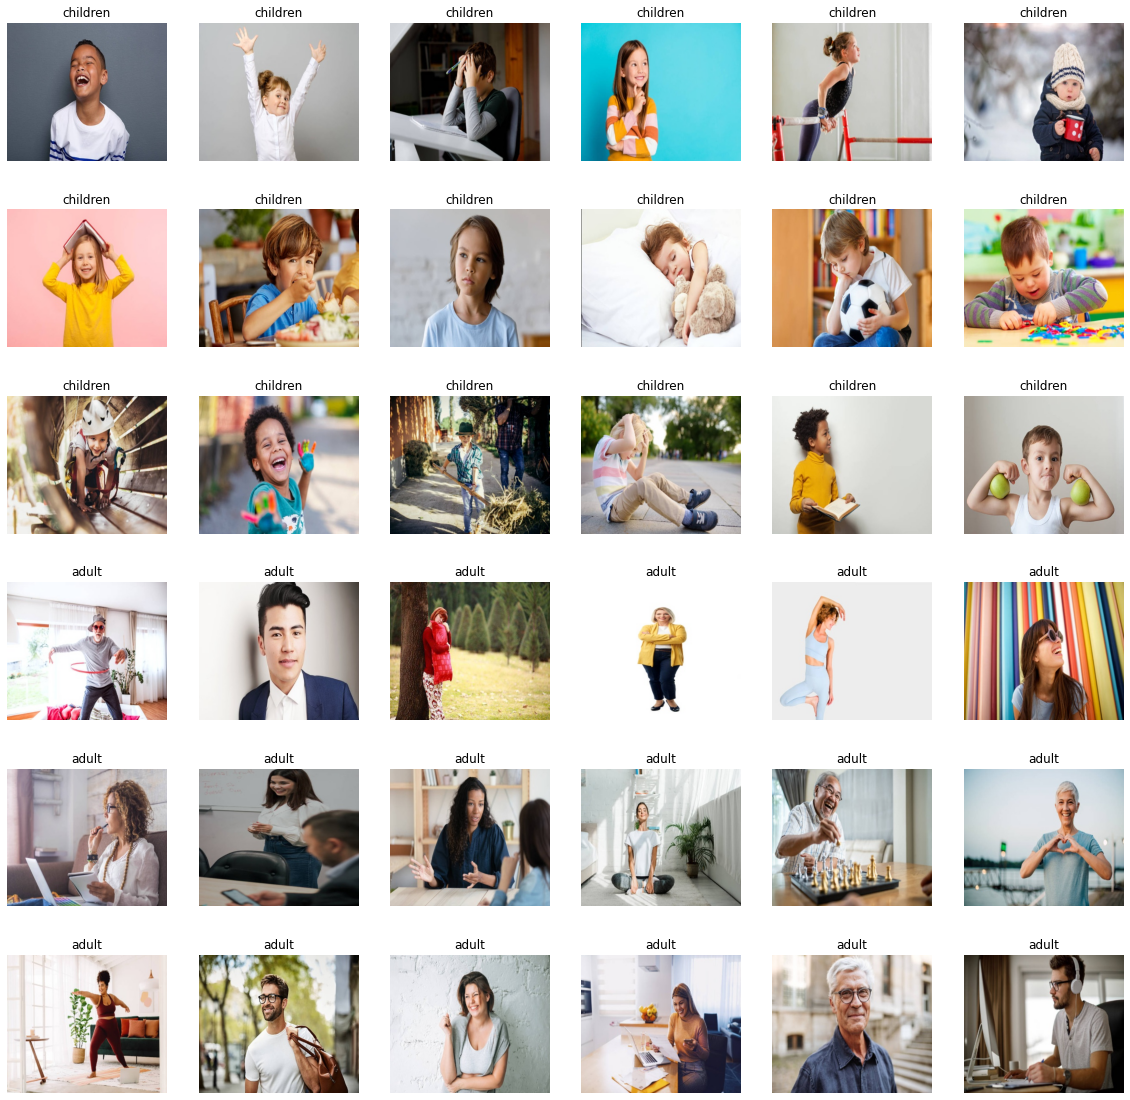

In [10]:
plt.figure(figsize=(20,20))
count=1
for n in range(2):
  for i in list(np.random.randint(0,len(image_files[n]),18)): 
      plt.subplot(6,6,count)
      image=cv2.imread(image_files[n][i])
      image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(np.real(image))
      plt.axis('off')
      plt.title("children") if n==0 else plt.title("adult")
      count+=1

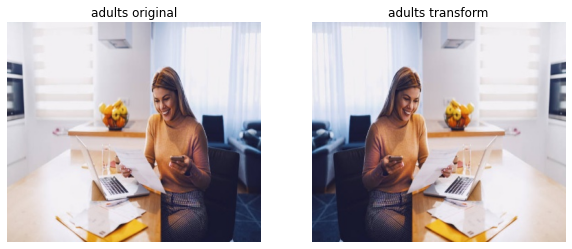

In [11]:
transform=A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomSizedCrop(
        min_max_height=[210, 300],
        height=370, 
        width=370,
        p=0.6)
])

aug_random_imshow(96,'adults',transform)

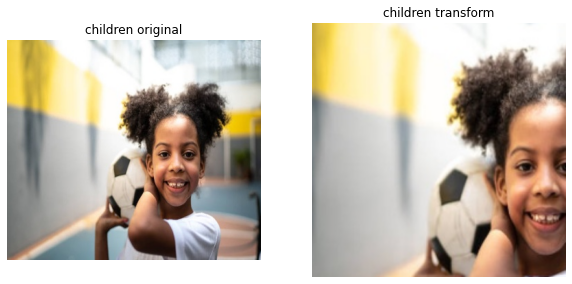

In [12]:
aug_random_imshow(96,'children',transform)

In [13]:
class CustomDataset(Dataset):
  def __init__(self,images_paths,targets,To_tensor,transforms=None):
    super(CustomDataset,self).__init__()
    self.image_paths=images_paths
    self.targets=targets
    self.To_tensor=To_tensor
    self.transforms=transforms
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self,idx):
    image_path=self.image_paths[idx]
    target=image_path.split('/')[-2]
    label=self.targets[target]

    image=cv2.imread(image_path)
    
    if self.transforms:
      image=self.transforms(image=image)
      image=Image.fromarray(image['image'].astype(np.uint8))
    else:
      image=Image.fromarray(image.astype(np.uint8))
    image=self.To_tensor(image)
    label=torch.tensor(label)

    return image.clone().detach(), label

In [14]:
train,valid=train_test_split(image_paths, test_size=0.2, shuffle=True, random_state=34)

In [15]:
To_tensor=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    ),
    transforms.Resize(
        size=(370,370)
    )
])

trian_transforms=A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomSizedCrop(
        min_max_height=[210, 300],
        height=370, 
        width=370,
        p=0.6)
])



train_dataset=CustomDataset(train,df_labels,To_tensor,trian_transforms)
valid_dataset=CustomDataset(valid,df_labels,To_tensor)

train_dataloader=DataLoader(
    train_dataset,
    pin_memory=True,
    batch_size=CFG["BATCH"],
    num_workers=2,
    shuffle=True
    )

valid_dataloader=DataLoader(
    valid_dataset,
    pin_memory=True,
    batch_size=CFG["BATCH"],
    num_workers=2,
    shuffle=True
    )

In [16]:
class BaseModel(nn.Module):
  def __init__(self):
    super(BaseModel,self).__init__()
    self.model=timm.create_model('efficientnet_b4')
    self.SiLU=nn.SiLU(inplace=False)
    self.dropout=nn.Dropout(p=0.2)
    self.classifier = nn.Linear(1000, 2)  
    nn.init.xavier_normal_(self.classifier.weight)

  def forward(self,x):
    x = self.model(x)
    x = self.SiLU(x)
    x = self.dropout(x)
    x = self.classifier(x)
    return x

# Mixup Augmentation
Mixup is a data augmentation technique that came out to solve the memorization problem of deep learning models or sensitive issues in adversarial examples.(ex overfitting)

[Papers with code](https://paperswithcode.com/method/mixup)

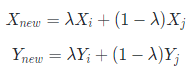
​






Data augmentation according to the above formula is all that mixup is about.

In [17]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ✔EarlyStopping

In the case of an overfitting model, as the epoch increases, the val_loss decreases and then increases again. At this time, it is a callback function that terminates the learning.

***Args:***

**patience (int)**: how long to wait after validation loss improves
<br>
Default: 7
            
**verbose (bool)**: If True, output improvement message for each validation loss <br>
Default: False
            
**delta (float)**: the smallest change in the monitored quantity that is considered improved <br>
Default: 0
            
**path (str)**: checkpoint storage path <br>
Default: '/kaggle/working/models/checkpoint.pt'
                            


In [18]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='/kaggle/working/models/checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter%10==0:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Train

In [19]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model=BaseModel().to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=CFG['LR'])
criterion=nn.CrossEntropyLoss().to(device)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=100,eta_min=0.001)

scaler = torch.cuda.amp.GradScaler()
os.makedirs('/kaggle/working/models')
early_stopping = EarlyStopping(patience = 100, verbose = True, path ='/kaggle/working/models/checkpoint.pt')

In [20]:
for epoch in range(1,CFG['EPOCH']+1):
  model_preds=[]
  true_labels=[]
  train_loss_list=[]

  valid_preds=[]
  valid_labels=[] 
  valid_loss_list=[]
  best_score=int(1e9)
  model.train()
  for data,label in train_dataloader:
    data,label=data.to(device),label.to(device)

    data, targets_a, targets_b, lam = mixup_data(data, label)
    data, targets_a, targets_b = map(torch.autograd.Variable, (data, targets_a, targets_b))

    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
      output=model(data)
    loss=mixup_criterion(criterion, output, targets_a, targets_b, lam)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    train_loss_list.append(loss.item())
    model_preds+=output.argmax(1).detach().cpu().numpy().tolist()
    true_labels+=label.detach().cpu().numpy().tolist()
  if epoch%10==0:
      print(f'epoch {epoch} : "train loss : {np.mean(train_loss_list):.5f}", "train acc : {accuracy_score(true_labels, model_preds)}"')

  model.eval()
  with torch.no_grad():
    for data,label in valid_dataloader:
      data,label=data.to(device),label.to(device)
      with torch.cuda.amp.autocast():
        output=model(data)
      valid_loss=criterion(output,label)
      valid_loss_list.append(valid_loss.item())
      valid_preds+=output.argmax(1).detach().cpu().numpy().tolist()
      valid_labels+=label.detach().cpu().numpy().tolist()
  if epoch%10==0:
    print(f'epoch {epoch} : "valid loss : {np.mean(valid_loss_list):.5f}", "valid acc : {accuracy_score(valid_labels, valid_preds)}"')
  early_stopping(np.mean(valid_loss_list), model)
  if early_stopping.early_stop:
      print("Early stopping")
      break
  if scheduler is not None:
    scheduler.step() 

Validation loss decreased (inf --> 0.693359).  Saving model ...
Validation loss decreased (0.693359 --> 0.684961).  Saving model ...
Validation loss decreased (0.684961 --> 0.658008).  Saving model ...
epoch 10 : "train loss : 0.67222", "train acc : 0.5606617647058824"
epoch 10 : "valid loss : 1.39736", "valid acc : 0.5147058823529411"
EarlyStopping counter: 10 out of 100
epoch 20 : "train loss : 0.66912", "train acc : 0.5643382352941176"
epoch 20 : "valid loss : 1.98750", "valid acc : 0.5735294117647058"
EarlyStopping counter: 20 out of 100
Validation loss decreased (0.658008 --> 0.628613).  Saving model ...
epoch 30 : "train loss : 0.66777", "train acc : 0.5533088235294118"
epoch 30 : "valid loss : 0.62480", "valid acc : 0.6102941176470589"
Validation loss decreased (0.628613 --> 0.624805).  Saving model ...
epoch 40 : "train loss : 0.60461", "train acc : 0.6544117647058824"
epoch 40 : "valid loss : 1.86797", "valid acc : 0.5735294117647058"
EarlyStopping counter: 10 out of 100
epoch

# Inference

In [21]:
image_files=[[os.path.join('/kaggle/input/children-vs-adults-images/test',label,x) for x in os.listdir(os.path.join('/kaggle/input/children-vs-adults-images/test',label))] for label in labels]

test=[]
for i in range(2):
  for j in range(len(image_files[i])):
    current = image_files[i]
    test.append(current[j])

In [22]:
test_dataset=CustomDataset(test,df_labels,To_tensor)
model.load_state_dict(torch.load("/kaggle/working/models/checkpoint.pt",map_location=device))# 내가 학습시킨 모델 weight를 모델에 입혀줍니다.

test_dataloader=DataLoader(
    test_dataset,
    pin_memory=True,
    batch_size=CFG["BATCH"],
    num_workers=2,
)

In [23]:
model.eval()
test_loss=[]
test_labels=[]
test_preds=[]
with torch.no_grad():
  for data,label in test_dataloader:
    data,label=data.to(device),label.to(device)
    output=model(data)
    loss=criterion(output,label)
    test_loss.append(loss.item())
    test_preds+=output.argmax(1).detach().cpu().numpy().tolist()
    test_labels+=label.detach().cpu().numpy().tolist()
  print(f'"test loss : {np.mean(test_loss):.5f}", "test acc : {accuracy_score(test_labels, test_preds)}"')

"test loss : 0.46459", "test acc : 0.8"


# ✔Grad cam

XAI is an explanable artificial intelligence (eXplainable AI) technique that adds a convincing explanation to the results of an artificial intelligence model.

There are many types of XAI techniques. Among them, we would like to analyze the model through CAM, which is widely used in the vision field.
CAM is a technique that expresses in a heat map what part of the image our model saw and derived the result.


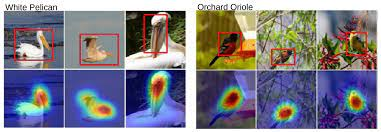

*Fig1. CAM*



There are various types of CAM, and I conducted the analysis with GradCAM, which was developed to make implementation easier in the existing CAM.

In [24]:
target_layers = [model.model.conv_head]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
model.load_state_dict(torch.load("/kaggle/working/models/checkpoint.pt",map_location=device))# 내가 학습시킨 모델 weight를 모델에 입혀줍니다.

<All keys matched successfully>

In [25]:
def grad_cam_image(idx,name):
  path=f"/kaggle/input/children-vs-adults-images/train/{name}/{idx}.jpg"
  img=cv2.imread(path)
  img = Image.fromarray(img)
  img=To_tensor(img)
  img = torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))(img)
  img = img.unsqueeze(0)
  img=img.to(device)

  pred = int(torch.argmax(torch.nn.Softmax()(model(img))).item())
  targets = [ClassifierOutputTarget(pred)]

  image=cv2.imread(path,cv2.IMREAD_COLOR)
  image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  image=cv2.resize(image, dsize=(370, 370))

  grayscale_cam = cam(input_tensor=img, targets=targets)
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)

  plt.axis('off')
  plt.imshow(visualization)


In the case of adult photos, the model is making predictions by looking at faces.But in the case of an image of a child, it is predicted by looking at the background. It's not what we want our models to do.


XAI techniques are particularly important for medical diagnostics and other areas of high responsibility for outcomes.
In fact, the performance of the model is good, but I know that there are many cases where it cannot be applied to the actual service because it cannot give an explanation for the result.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


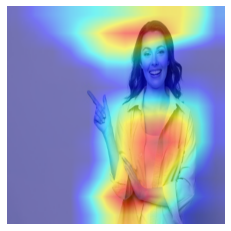

In [182]:
grad_cam_image(175,'adults')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


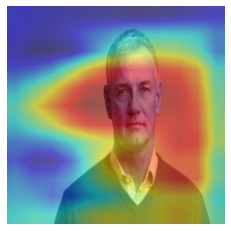

In [183]:
grad_cam_image(135,'adults')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


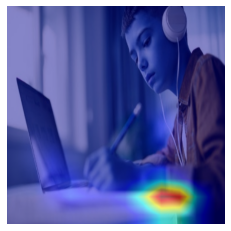

In [189]:
grad_cam_image(91 ,'children')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


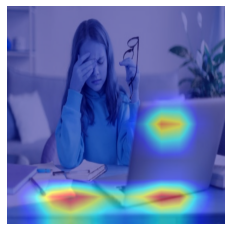

In [190]:
grad_cam_image(102 ,'children')